# Amazon Product Reviews

### imports and setup

In [1]:
import tensorflow as tf
import tensorflow_hub as hu

In [2]:
import os as os
# import keras as ke
import pandas as pd
import numpy as np
import copy as cp
import pickle as pk
import datetime as dt
import gc
import shelve as she

In [3]:
os.environ['TFHUB_CACHE_DIR'] = '../TensorFlowCacheWin'

In [4]:
import sklearn as sk
import sklearn.metrics as skm
import sklearn.preprocessing as skp
import sklearn.model_selection as skms
import sklearn.pipeline as skpl
import sklearn.decomposition as skd
import sklearn.linear_model as sklm
import sklearn.dummy as sky
import sklearn.calibration as skc
from sklearn.utils import validation as skuv

In [5]:
import matplotlib as mat
from matplotlib import pyplot as plt
import pylab as pyl

In [6]:
import seaborn as sns

In [7]:
from IPython.display import HTML

In [8]:
from scipy import optimize as sco

In [9]:
import pwml as pw
from pwml.classifiers import hierarchical as hc
from pwml.classifiers import features as fe
from pwml.classifiers import embedders as em

print('Using Pwml version {}'.format(pw.__version__))

Using Pwml version 0.9.9


In [10]:
from pwml.utilities import filehelpers as fh
from pwml.utilities import mssqlhelpers as ms
from pwml.utilities import classificationhelpers as ch
from pwml.utilities import graphichelpers as gh

In [11]:
print('Using TensorFlow version {}'.format(tf.__version__))
print('Using TensorFlowHub version {}'.format(hu.__version__))

Using TensorFlow version 2.1.0
Using TensorFlowHub version 0.8.0


In [12]:
sk.show_versions()


System:
    python: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
executable: C:\ProgramData\Anaconda3\envs\pwml-cal-env\python.exe
   machine: Windows-10-10.0.19041-SP0

Python dependencies:
          pip: 20.2.4
   setuptools: 50.3.0.post20201006
      sklearn: 0.23.2
        numpy: 1.19.1
        scipy: 1.5.2
       Cython: 0.29.21
       pandas: 1.1.3
   matplotlib: 3.3.1
       joblib: 0.17.0
threadpoolctl: 2.1.0

Built with OpenMP: True


In [13]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [14]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [15]:
# Initialize Matplotlib / Seaborn styles
gh.GraphicsStatics.initialize_matplotlib_styles()

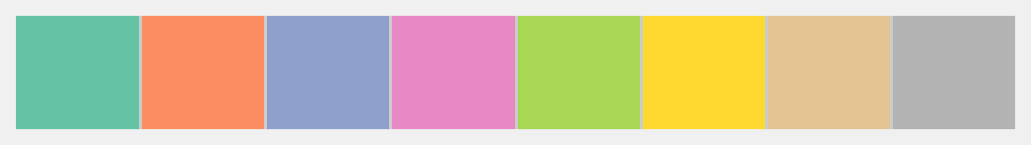

In [16]:
# Color palette for the notebook
sns.palplot(gh.GraphicsStatics.g_palette)

In [56]:
%load_ext vscode_debugger_magic
%vscodedebugger -t 30

ModuleNotFoundError: No module named 'vscode_debugger_magic'

### environment preparation

#### cache

In [17]:
cache_folder = os.path.join('data', 'cache')

#### project

In [18]:
base_folder = 'projects'

In [19]:
project_name = 'amazon-product-reviews'

In [20]:
project_folder = fh.create_if_not_exists(
    os.path.join(
        base_folder,
        project_name))

#### experiment

In [21]:
# Either use an existing one
experiment_name = '2020-12-07-14-44-34'

# Or use a new model folder
if experiment_name is None:
    experiment_name = fh.get_stamp_text(
        stamp=dt.datetime.utcnow())

In [22]:
experiment_folder = fh.create_if_not_exists(
    os.path.join(
        base_folder,
        project_name,
        experiment_name))

#### setup

In [23]:
full_data_file = 'FULL_DATA.csv'
zip_full_data_file = 'FULL_DATA.zip'

zip_full_data_filepath = os.path.join(
    experiment_folder, 
    zip_full_data_file)

print('full data: {0}'.format(zip_full_data_filepath))

full data: projects\amazon-product-reviews\2020-12-07-14-44-34\FULL_DATA.zip


In [24]:
training_data_file = 'TRAINING_DATA.csv'
zip_training_data_file = 'TRAINING_DATA.zip'

zip_training_data_filepath = os.path.join(
    experiment_folder, 
    zip_training_data_file)

print('training data: {0}'.format(zip_training_data_filepath))

training data: projects\amazon-product-reviews\2020-12-07-14-44-34\TRAINING_DATA.zip


In [25]:
testing_data_file = 'TESTING_DATA.csv'
zip_testing_data_file = 'TESTING_DATA.zip'

zip_testing_data_filepath = os.path.join(
    experiment_folder, 
    zip_testing_data_file)

print('testing data: {0}'.format(zip_testing_data_filepath))

testing data: projects\amazon-product-reviews\2020-12-07-14-44-34\TESTING_DATA.zip


In [26]:
model_file = 'MODEL.p'

model_filepath = os.path.join(
    experiment_folder, 
    model_file)

print('model: {0}'.format(model_filepath))

model: projects\amazon-product-reviews\2020-12-07-14-44-34\MODEL.p


### load data and fit model

#### loading full dataset

In [27]:
df_full_data = pd.read_csv(
    filepath_or_buffer='data/full_50k.csv.gz',
    compression='gzip')

In [28]:
df_full_data.head(5)

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B000E46LYG,Golden Valley Natural Buffalo Jerky,A3MQDNGHDJU4MK,0/0,3.0,-1,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,B000GRA6N8,Westing Game,unknown,0/0,5.0,860630400,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,B000GRA6N8,Westing Game,unknown,0/0,5.0,883008000,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,B000GRA6N8,Westing Game,unknown,0/0,5.0,897696000,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,B00000DMDQ,I SPY A is For Jigsaw Puzzle 63pc,unknown,2/4,5.0,911865600,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles


In [29]:
df_full_data['Title'].replace(np.NaN, 'n/a', inplace=True)
df_full_data['Text'].replace(np.NaN, 'n/a', inplace=True)
df_full_data['Cat12'] = df_full_data['Cat1'] + ' / ' + df_full_data['Cat2']

In [30]:
df_full_data.to_csv(
    path_or_buf=zip_full_data_filepath, 
    index=False, 
    header=True,
    compression={
        'method': 'zip', 
        'archive_name': full_data_file
    })

print('full data saved: {0}'.format(zip_full_data_filepath))

full data saved: projects\amazon-product-reviews\2020-12-07-14-44-34\FULL_DATA.zip


In [31]:
hc.HierarchicalClassifierModel.analyze_dataframe(
    data=df_full_data)

,count,unique,top,freq
productId,50000,24383,B000FSFNUE,159
Title,50000,22839,Pampers Baby Dry Diapers (Packaging May Vary),344
userId,50000,45838,unknown,1954
Helpfulness,50000,822,0/0,23337
Text,50000,49337,Length:,33
Cat1,50000,6,health personal care,12764
Cat2,50000,64,dogs,3485
Cat3,50000,473,unknown,2749
Cat12,50000,64,pet supplies / dogs,3485


In [32]:
df_training_data, df_testing_data = skms.train_test_split(
    df_full_data, 
    test_size=0.2,
    random_state=42,
    shuffle=True)

#### training data

In [33]:
df_training_data.head(5)

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3,Cat12
39087,B000K2NWNA,Alaskan Bear Treats All Natural Wild-Alaskan S...,ADTJ29AG1CZ01,1/1,4.0,1341014400,I bought this for my 18 mos old female mastiff...,pet supplies,dogs,health supplies,pet supplies / dogs
30893,B000GXEQI8,"Shazam 13"" Deluxe Collector Figure",A1LIH3I61P059G,0/0,4.0,1311120000,The figure has a good sturdy body build and ni...,toys games,action toy figures,figures,toys games / action toy figures
45278,B0002MHMFM,FlashMaster,ASEDBP1OD10EY,1/1,5.0,1356566400,Kicks flashcards to the trash. This little gem...,toys games,learning education,electronics,toys games / learning education
16398,B000GLRREU,Waterpik Ultra Water Flosser,A3C8OJ1409428J,1/1,4.0,1229904000,Waterpik was recommended by hygenist. I have a...,health personal care,personal care,oral hygiene,health personal care / personal care
13653,B0000Y8QQG,Dr Dennis Gross All-in-one Facial Cleanser Wit...,A1TKT92VSN2EH4,2/2,5.0,1209600000,I'm not one to write about skincare because I ...,beauty,skin care,face,beauty / skin care


In [34]:
# df_training_data['Title'].replace(np.NaN, 'n/a', inplace=True)
# df_training_data['Text'].replace(np.NaN, 'n/a', inplace=True)
# df_training_data['Cat12'] = df_training_data['Cat1'] + ' / ' + df_training_data['Cat2']

In [35]:
df_training_data.to_csv(
    path_or_buf=zip_training_data_filepath, 
    index=False, 
    header=True,
    compression={
        'method': 'zip', 
        'archive_name': training_data_file
    })

print('training data saved: {0}'.format(zip_training_data_filepath))

training data saved: projects\amazon-product-reviews\2020-12-07-14-44-34\TRAINING_DATA.zip


In [36]:
hc.HierarchicalClassifierModel.analyze_dataframe(
    data=df_training_data)

,count,unique,top,freq
productId,40000,20957,B000FSFNUE,134
Title,40000,19676,Pampers Baby Dry Diapers (Packaging May Vary),281
userId,40000,36902,unknown,1584
Helpfulness,40000,722,0/0,18745
Text,40000,39515,Length:,25
Cat1,40000,6,health personal care,10209
Cat2,40000,64,dogs,2822
Cat3,40000,466,unknown,2198
Cat12,40000,64,pet supplies / dogs,2822


#### testing data

In [37]:
df_testing_data.head(5)

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3,Cat12
33553,B0009YWHXA,"Bergan StarChaser Cat Toy, Assorted Colors, Co...",A1V02I3IXC4TAW,1/1,5.0,1321920000,My new little Balinese kitten is bonkers over ...,pet supplies,cats,toys,pet supplies / cats
9427,B0001NE2AK,Radica 20Q Artificial Intelligence Game - Colo...,A3Q6A35T4KQ5BF,0/0,4.0,1178668800,Randomly pick yes or no without looking at the...,toys games,electronics for kids,unknown,toys games / electronics for kids
199,B0000530K3,"Gillette Good News Disposable Razors for Men, ...",unknown,0/0,5.0,952819200,I didn't realize that these were a men's produ...,health personal care,personal care,shaving hair removal,health personal care / personal care
12447,B0009MFUOA,Philips Norelco 8140XL SpeedXL Men's Shaver,A3B4QM00D6DQTC,0/0,5.0,1200528000,bought this and it is quiet and works great ho...,health personal care,personal care,shaving hair removal,health personal care / personal care
39489,B0000ACXTE,"The Organic Sudz Company Bar Soap, C-Weed, 8-O...",A3KSIXQZJ5UHTG,6/6,4.0,1342310400,"Best $6000 I've ever spent. I was paying $12,0...",beauty,bath body,cleansers,beauty / bath body


In [38]:
# df_testing_data['Title'].replace(np.NaN, 'n/a', inplace=True)
# df_testing_data['Text'].replace(np.NaN, 'n/a', inplace=True)
# df_testing_data['Cat12'] = df_testing_data['Cat1'] + ' / ' + df_testing_data['Cat2']

In [39]:
df_testing_data.to_csv(
    path_or_buf=zip_testing_data_filepath, 
    index=False, 
    header=True,
    compression={
        'method': 'zip', 
        'archive_name': testing_data_file
    })

print('testing data saved: {0}'.format(zip_testing_data_filepath))

testing data saved: projects\amazon-product-reviews\2020-12-07-14-44-34\TESTING_DATA.zip


In [40]:
hc.HierarchicalClassifierModel.analyze_dataframe(
    data=df_testing_data)

,count,unique,top,freq
productId,10000,7396,B000FSFNUE,25
Title,10000,7103,Pampers Baby Dry Diapers (Packaging May Vary),63
userId,10000,9497,unknown,370
Helpfulness,10000,370,0/0,4592
Text,10000,9944,Length:,8
Cat1,10000,6,health personal care,2555
Cat2,10000,64,personal care,665
Cat3,10000,390,unknown,551
Cat12,10000,64,health personal care / personal care,665


#### define the model

In [41]:
model = hc.HierarchicalClassifierModel(
    model_name=project_name,
    cache_path=cache_folder,
    experiment_name=experiment_name,
    input_features=[
        fe.InputFeature(feature_name='Title', feature_type='longtext'),
        fe.InputFeature(feature_name='Text', feature_type='longtext') 
    ],
    output_feature_hierarchy=fe.OutputFeature(
        feature_name='Cat1'))
#         ,child_feature=fe.OutputFeature(
#             feature_name='Cat2',
#             child_feature=fe.OutputFeature(
#                 feature_name='Cat3'))))

#### Preprocess the training / testing data

In [42]:
model.load_from_dataframe(
    data=df_training_data,
    subset='training')

Processing output-feature "Cat1" for path ".".
 -> There are 6 classes and 40000 samples.
 -> Processed 10000 inputs so far.
 -> Processed 20000 inputs so far.
 -> Processed 30000 inputs so far.
 -> Processed 40000 inputs so far.
 -> There are 6 classes and 40000 samples.


In [43]:
model.load_from_dataframe(
    data=df_testing_data,
    subset='testing')

Processing output-feature "Cat1" for path "." for subset "testing".
 -> Processed 10000 inputs so far.
 -> There are 6 classes and 10000 samples.


In [44]:
model.get_dataset_balance_status().sort_values(by='label_count', ascending=True)

,label_names,label_count
label_idx,,
5,grocery gourmet food,3563
4,baby products,5043
0,pet supplies,5216
3,beauty,6399
1,toys games,9570
2,health personal care,10209


In [45]:
model.flush_embedders_cache()

In [46]:
model.get_min_samples_per_class(min_samples_per_class=10)

""


#### Hyperparameters tuning

In [47]:
model.tune_classifiers(
    min_pca=None,
    search_n_jobs=2,
    classifiers={
        'SGDClassifier': {
            'loss': ['log'],
            'alpha': np.logspace(start=-4, stop=-1, num=8),
            'max_iter': [1000],
            'n_iter_no_change':[25],
            'early_stopping': [True],
            'penalty': ['l1', 'l2'],
            'n_jobs': [6]
        },
    })

Tuning classifiers for output-feature "Cat1" for path ".".
    -> Train size: (40000); Test size: (10000) Number of classes (6).
    -> Tuning "SGDClassifier"
        -> Best validation score: 92.1001%
        -> Test score: 92.6072%
        -> Tuning time: 0:21:23 (1283.0s)
    -> Optimizing "SGDClassifier"
      -> Model calibration.
      -> Optimizing multiclass thresholds.
    -> Best classifier is "SGDClassifier" with a test score of 92.6072%
    -> Optimized test score: 92.4228%


In [48]:
model.get_summary(
    show_parameters=True).transpose()

,0
path,.
depth,0
nb_classes,6
nb_samples,40000
best_classifier,SGDClassifier
best_score,0.926072
fit_time,1283
SGDClassifier__alpha,0.0001
SGDClassifier__early_stopping,True
SGDClassifier__loss,log


In [49]:
model.save_model(
    filepath=model_filepath)

Model saved in "projects\amazon-product-reviews\2020-12-07-14-44-34\MODEL.p"


#### Inspect results

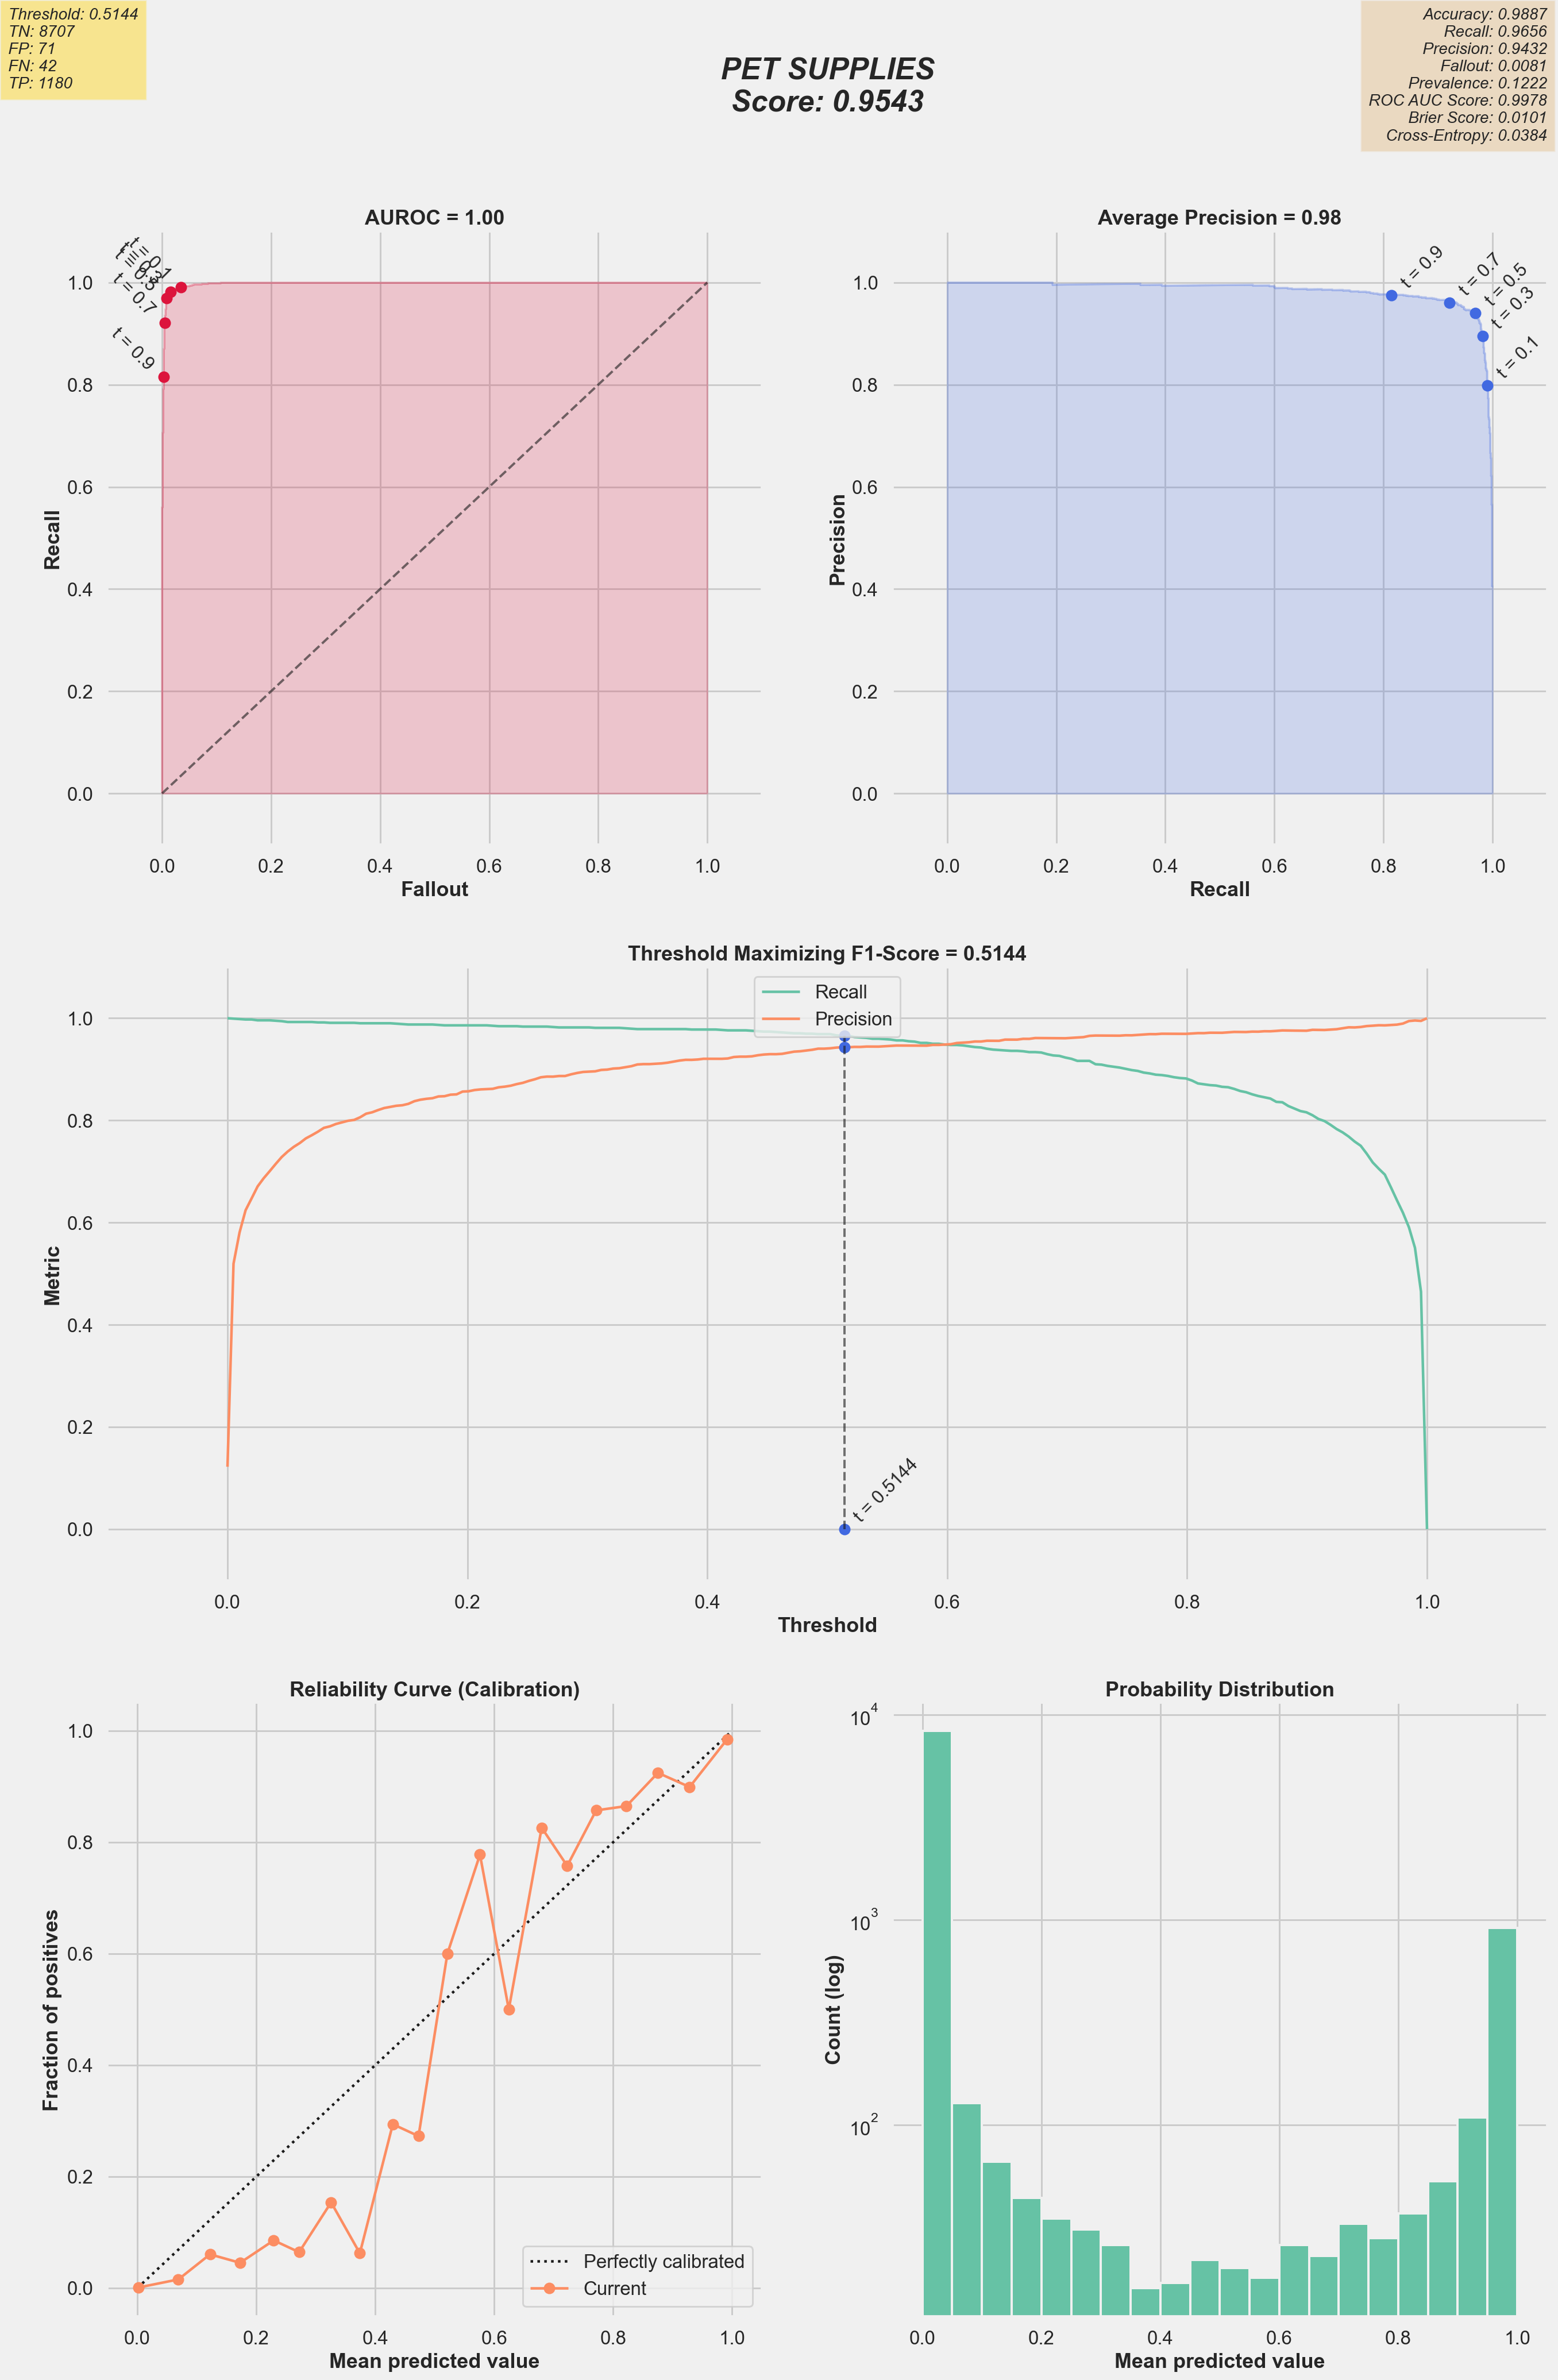

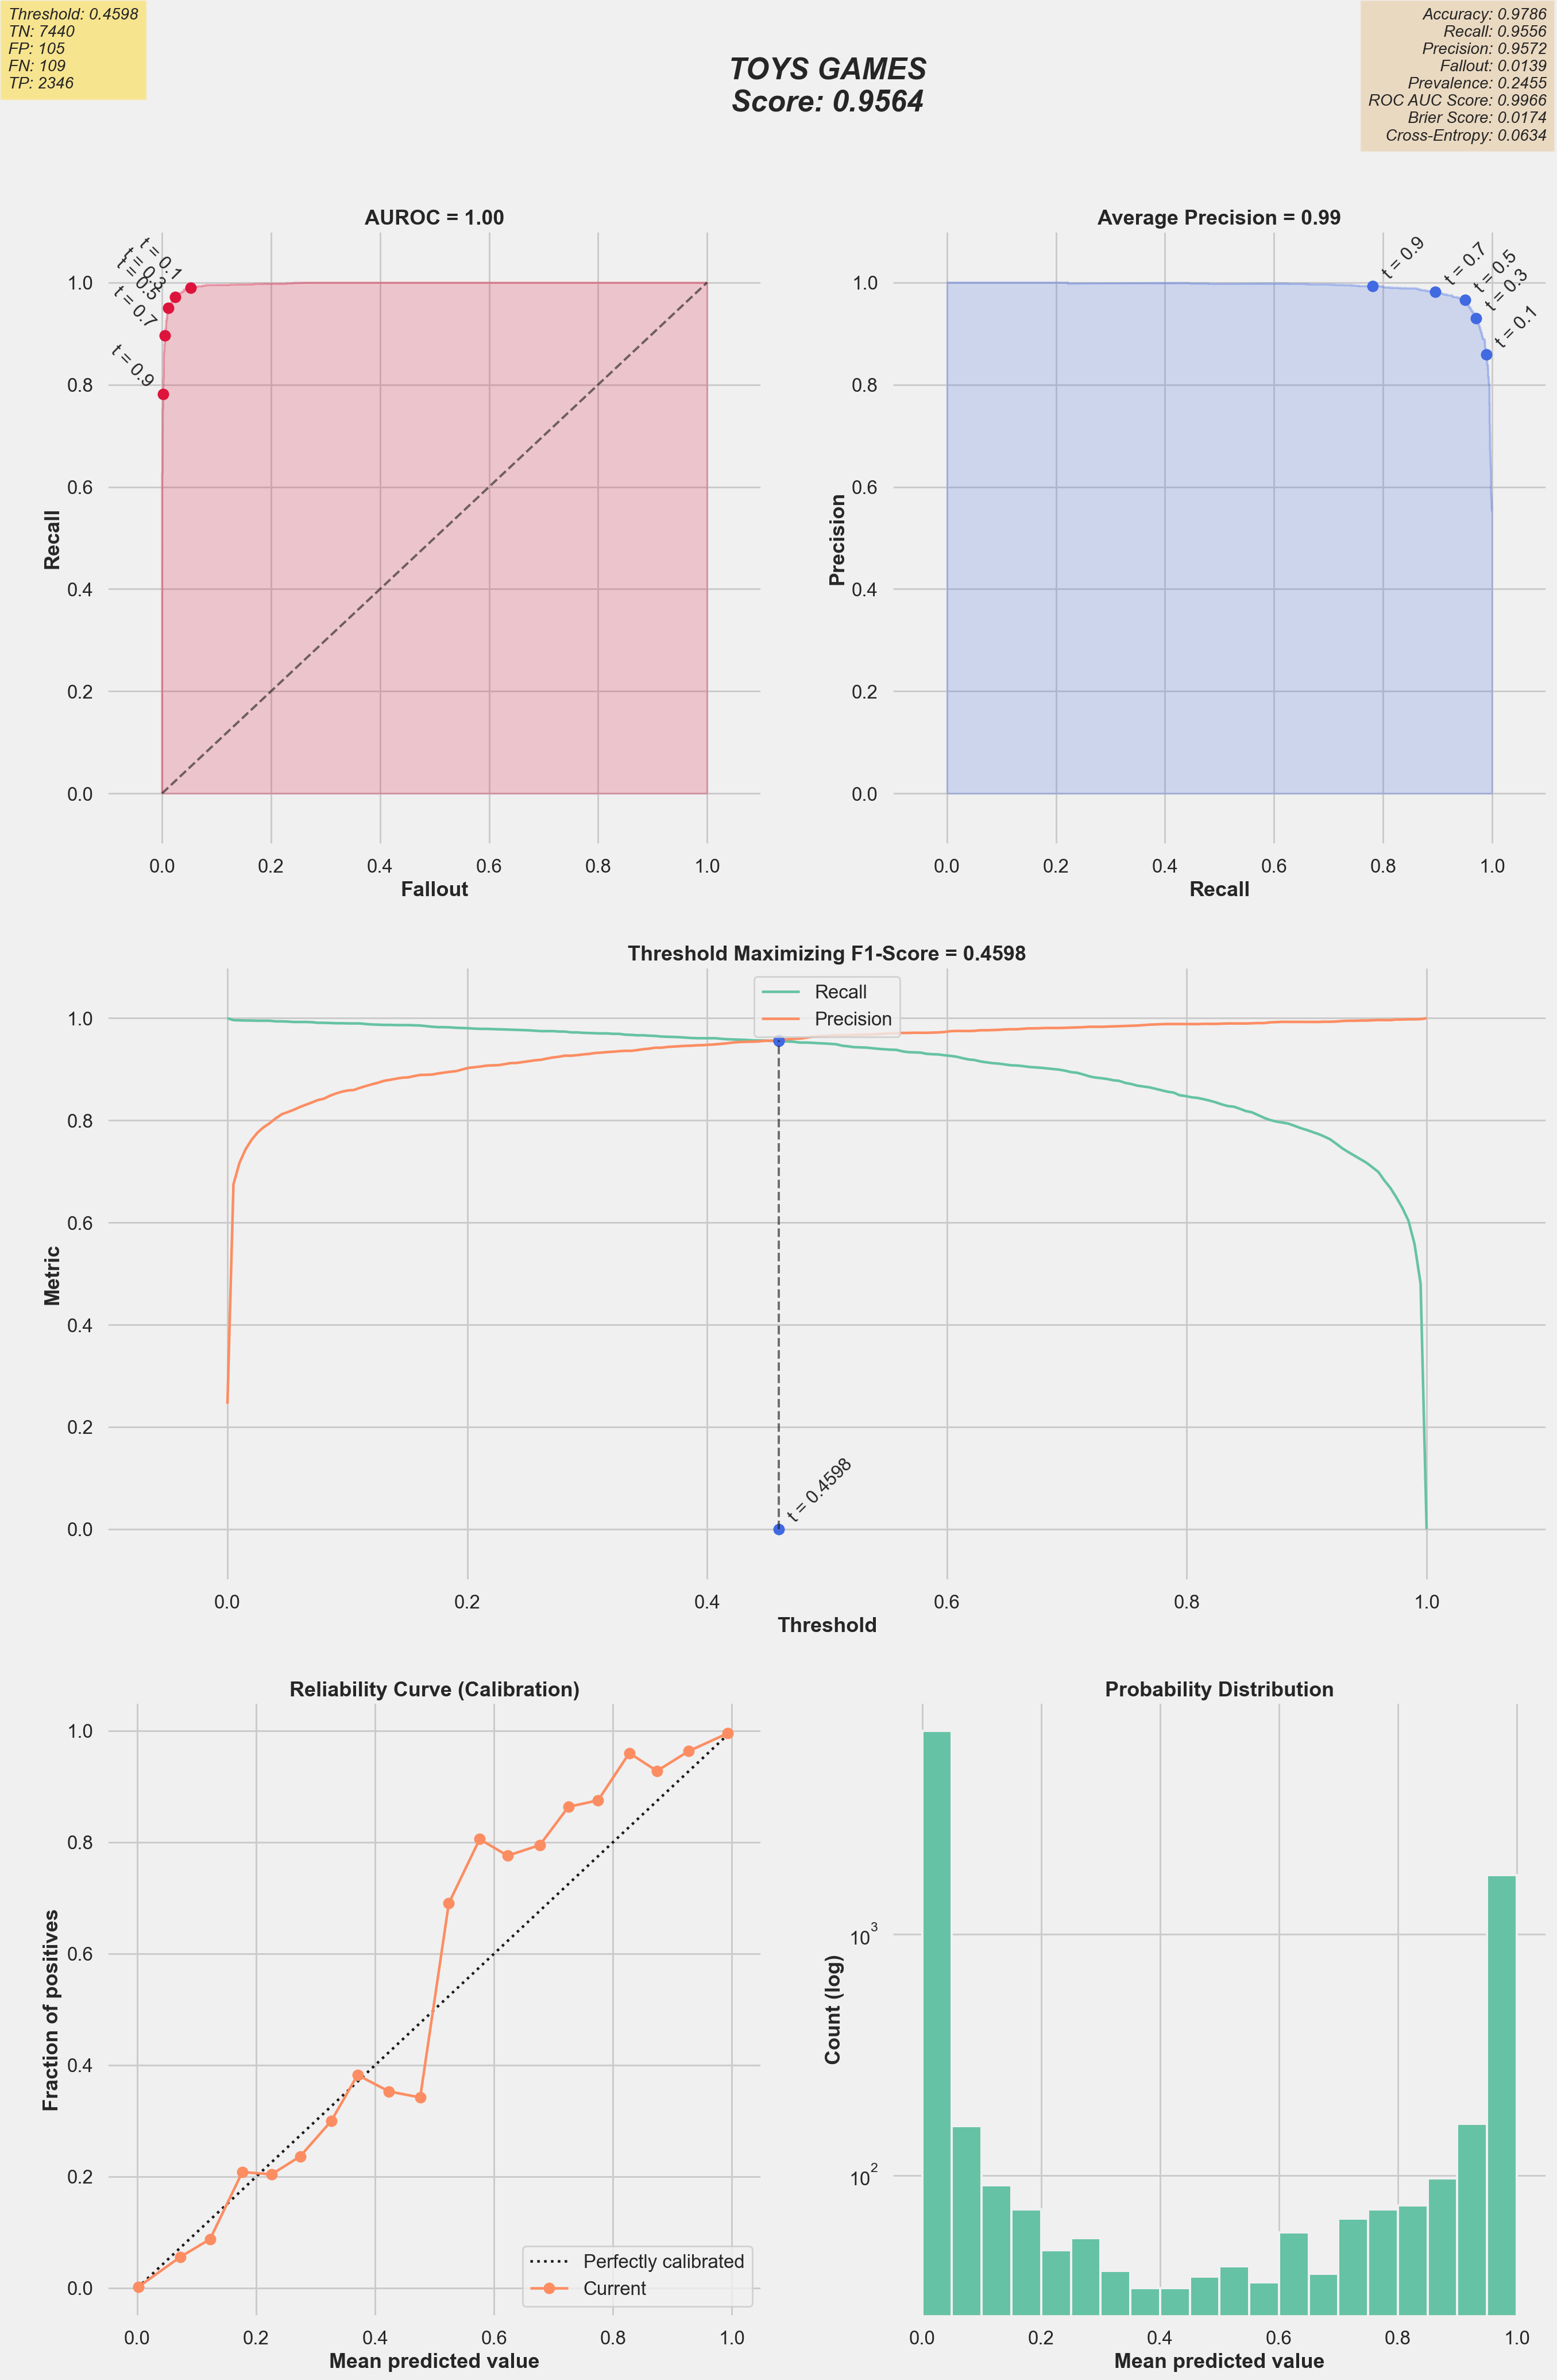

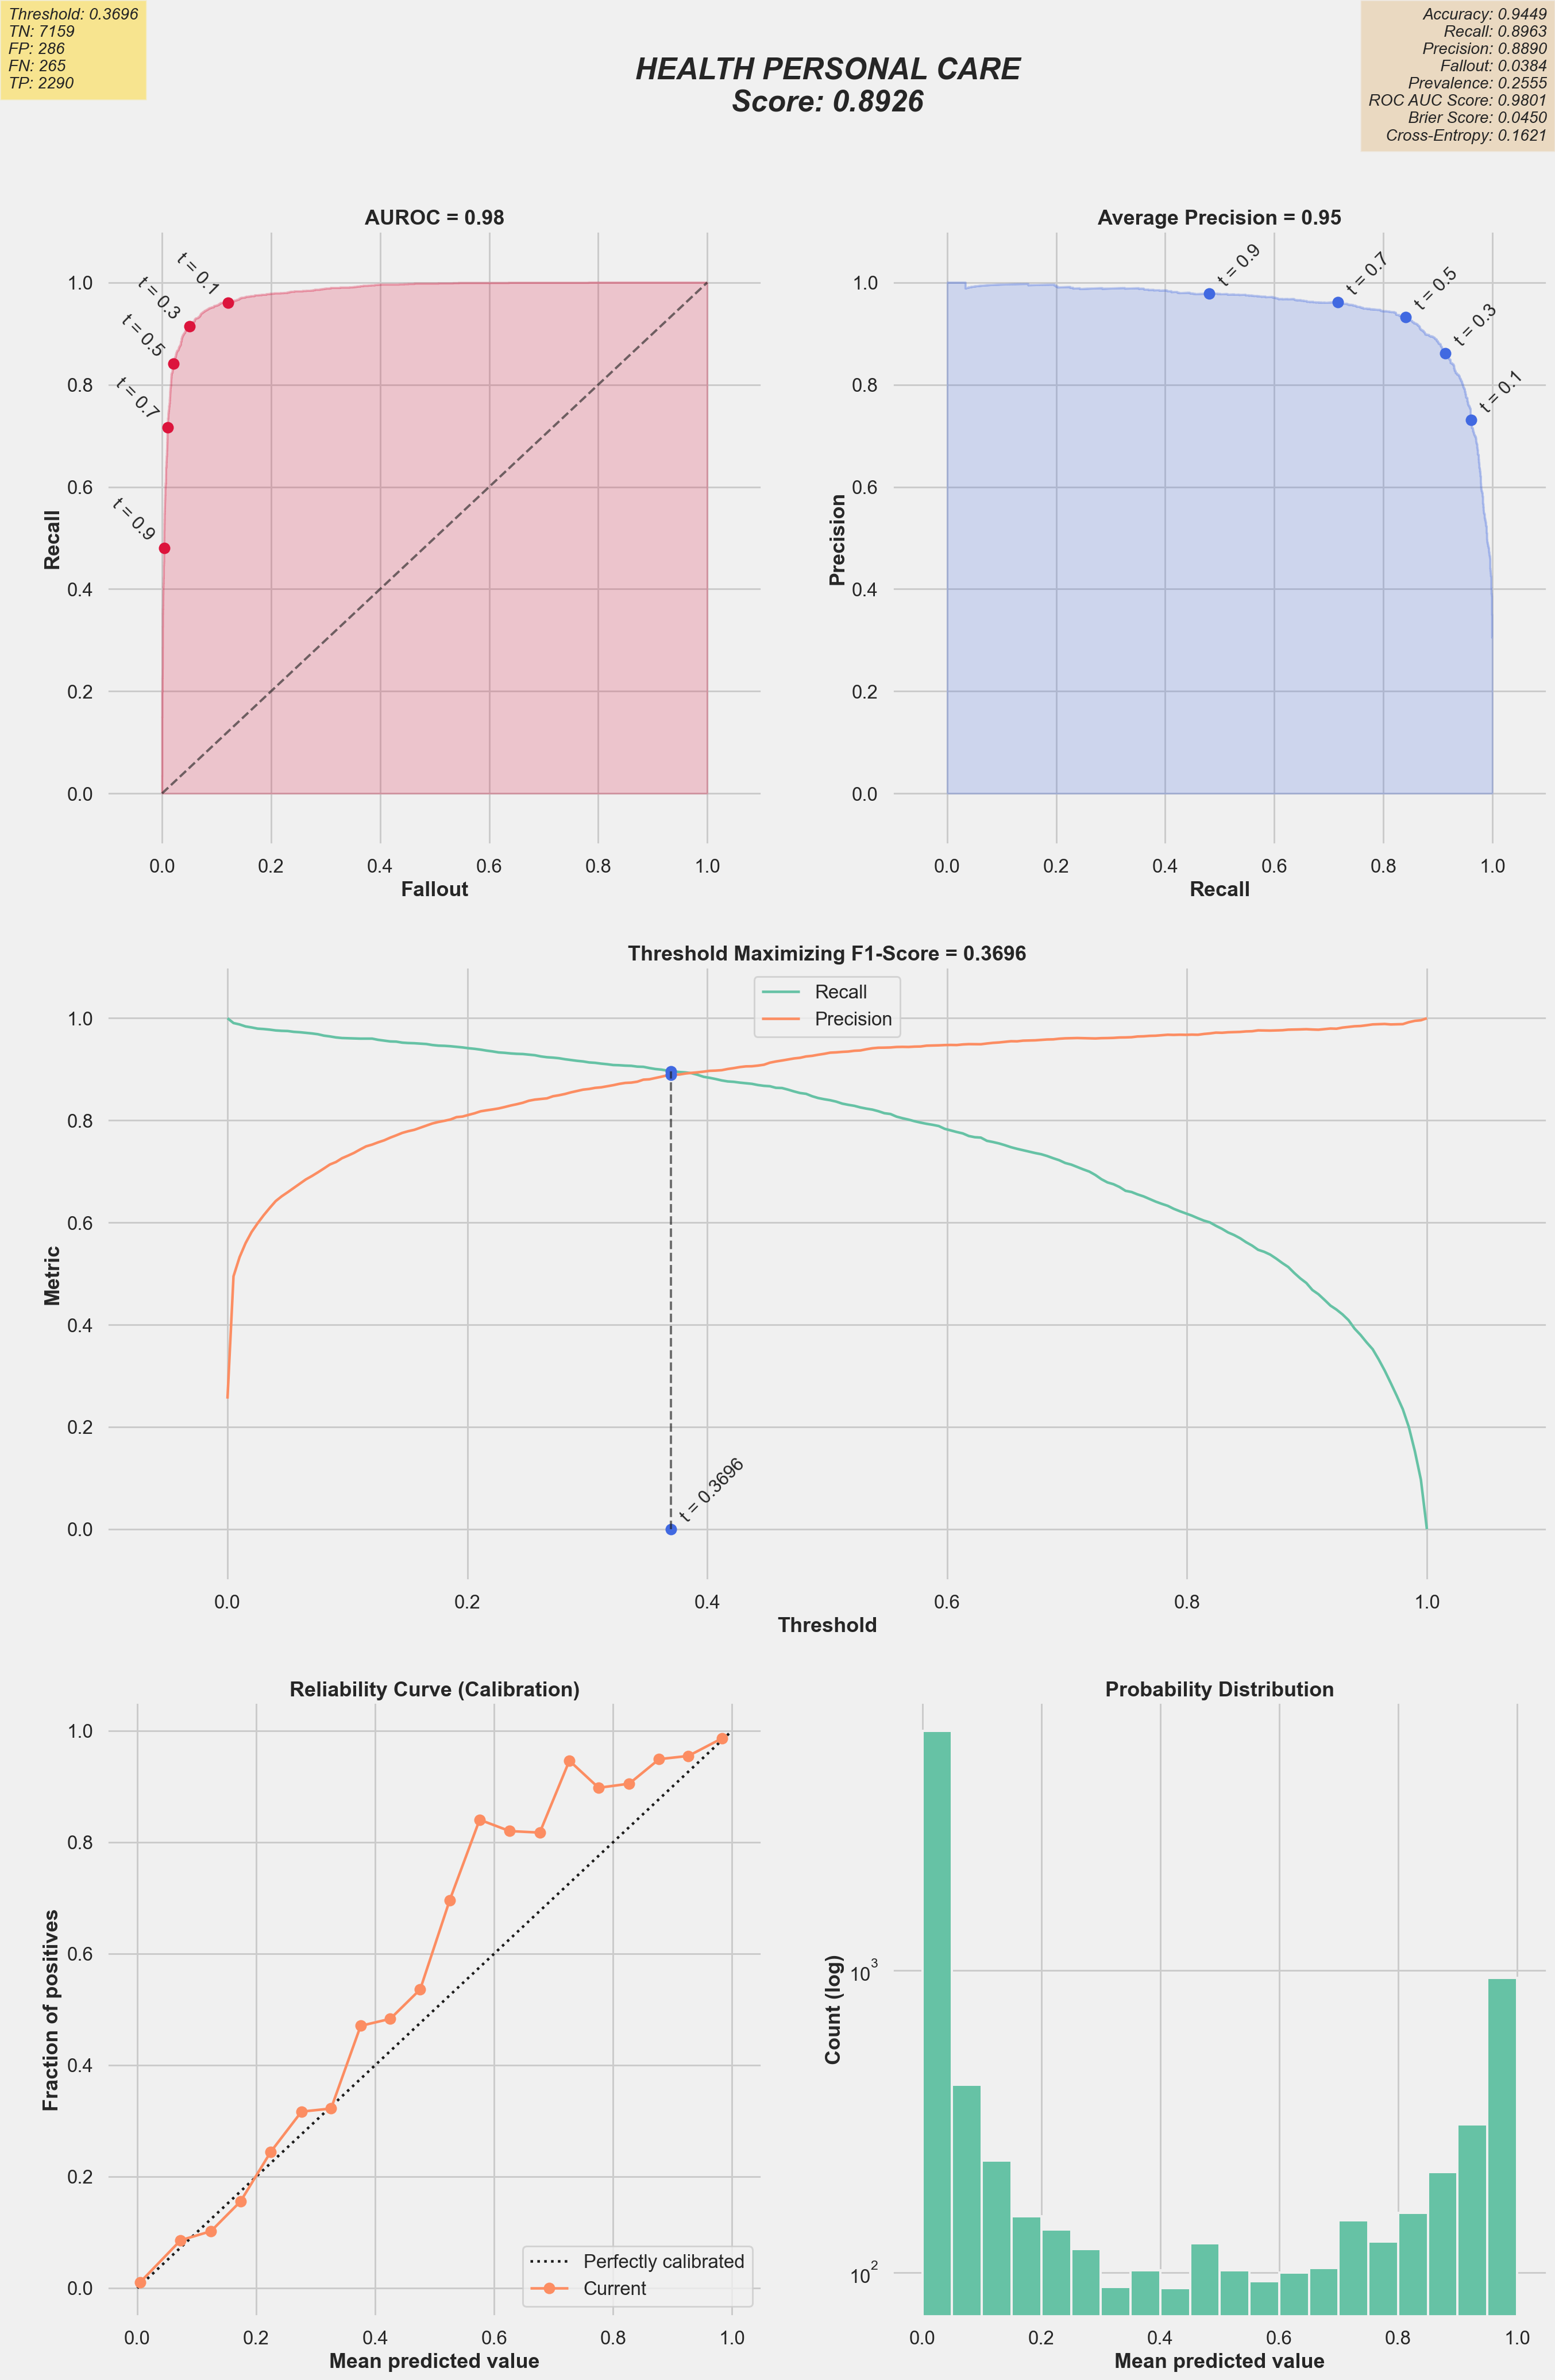

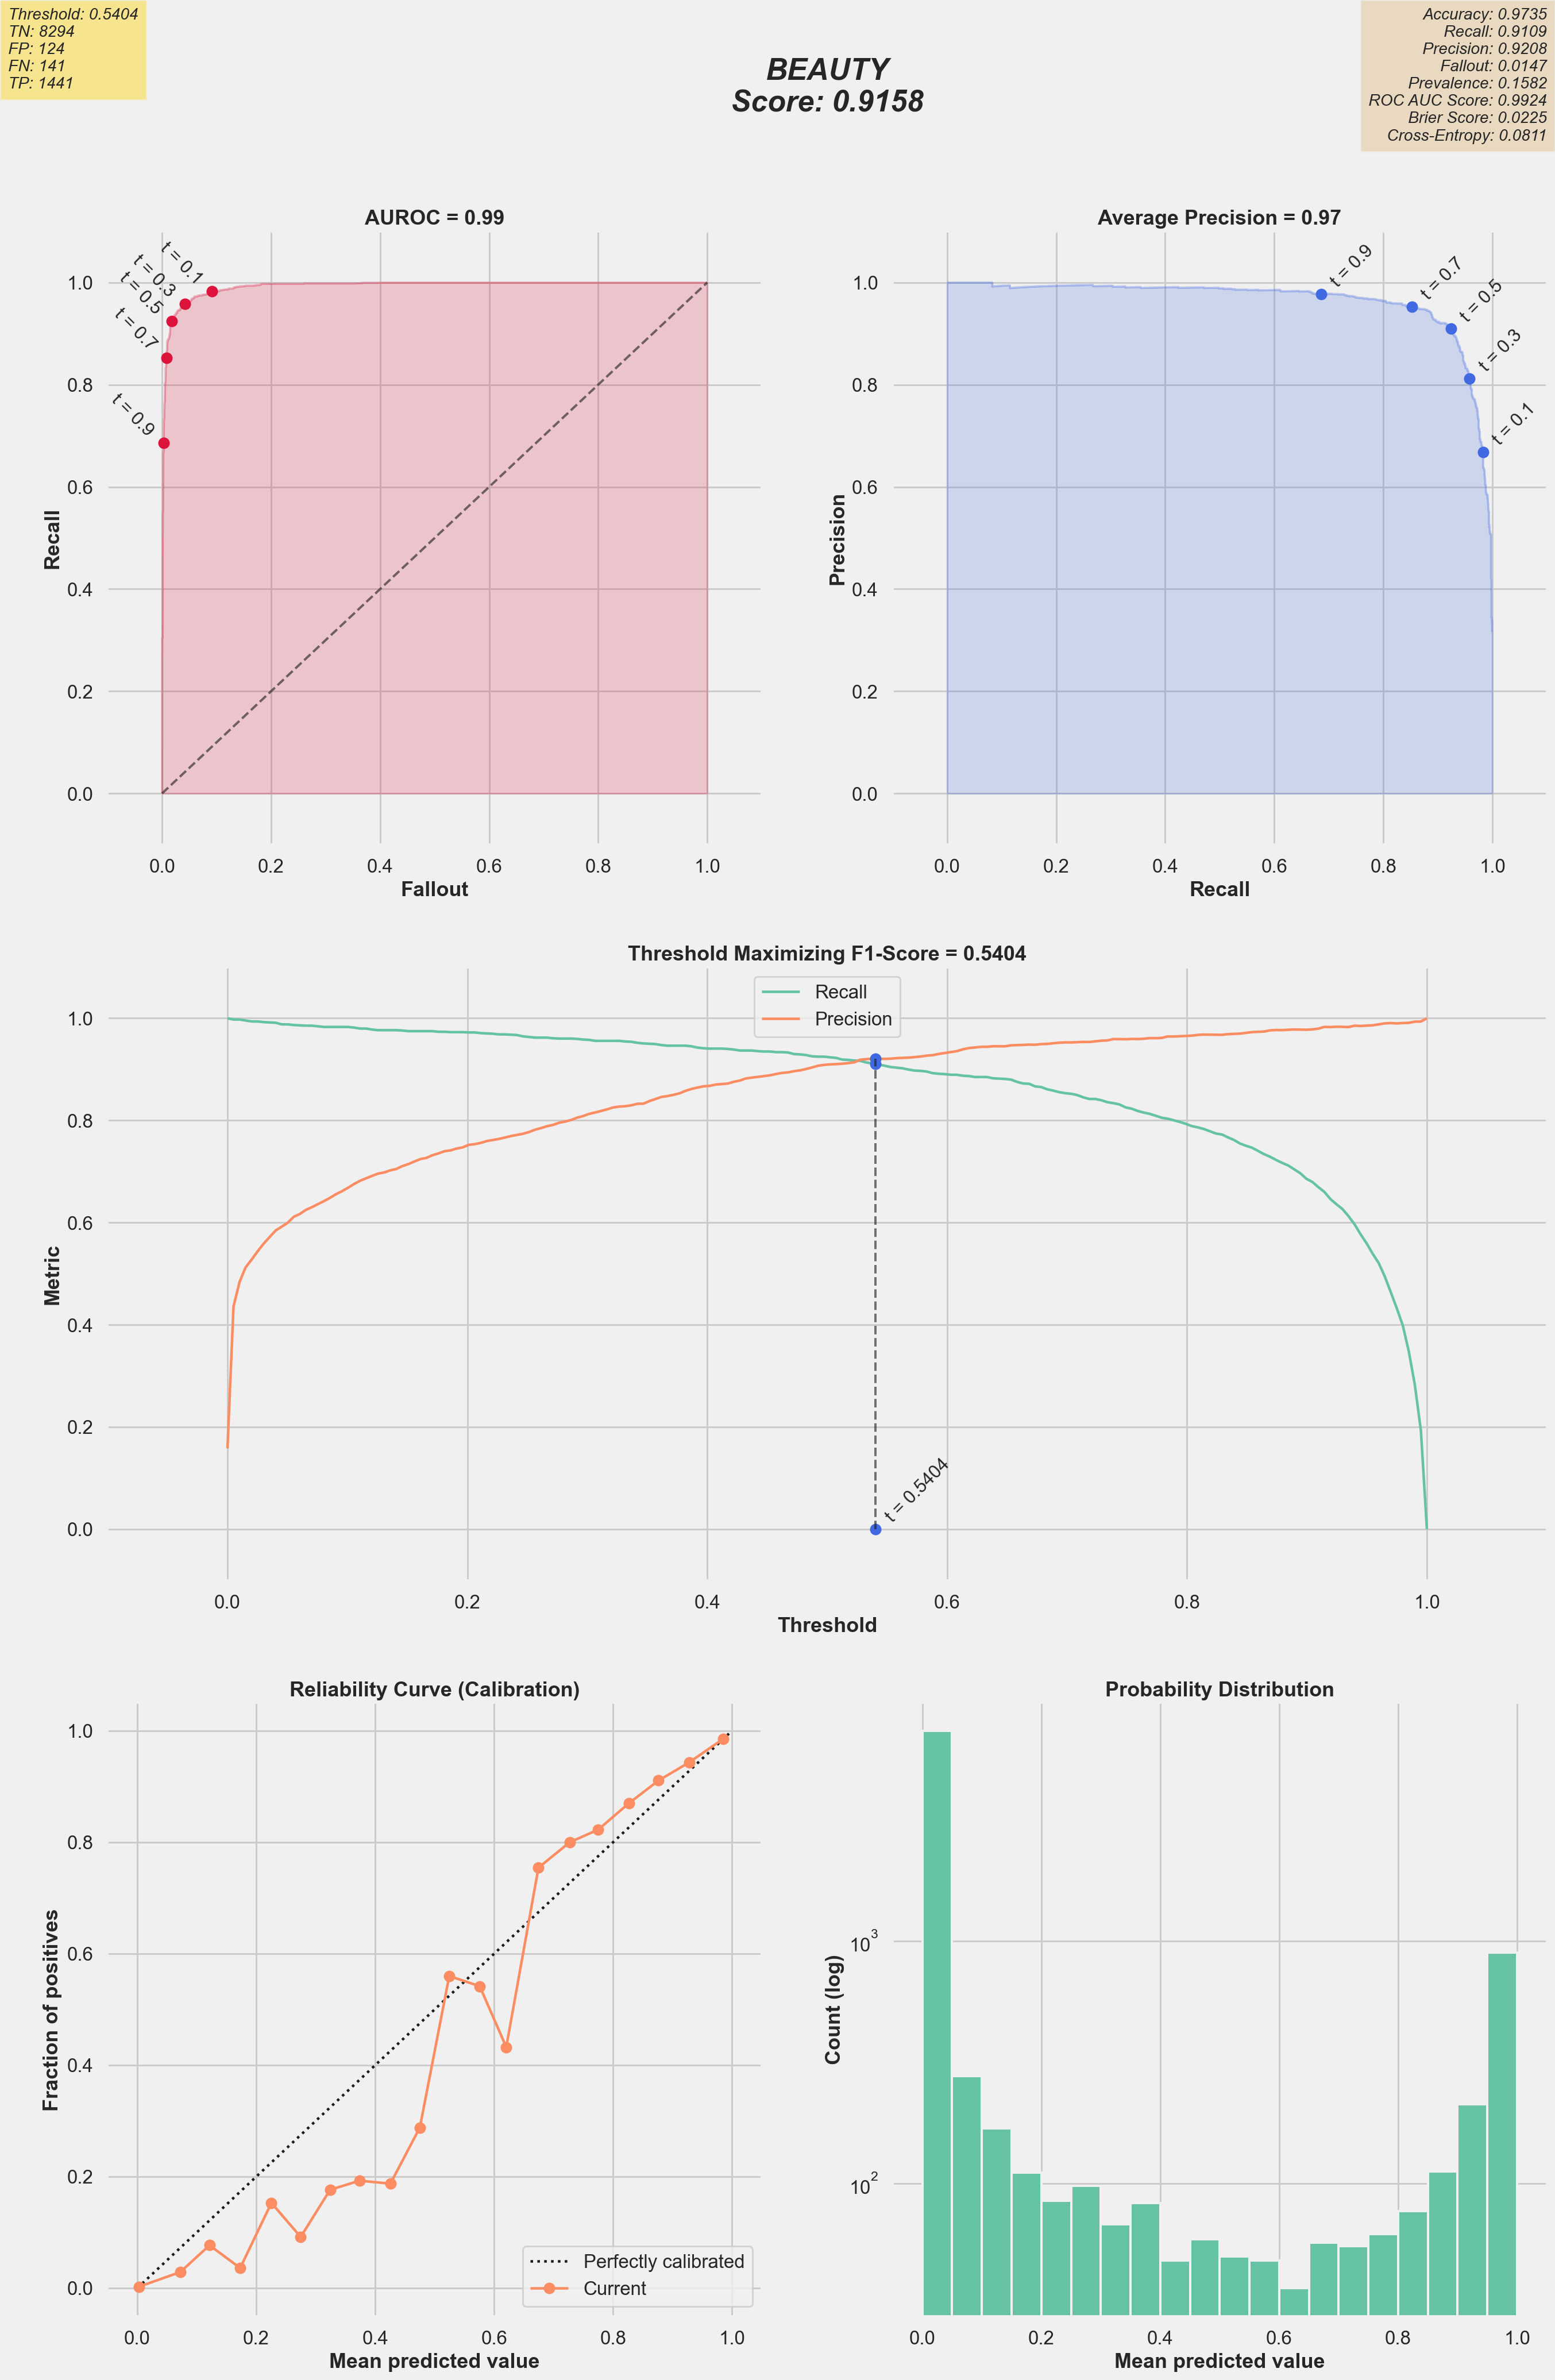

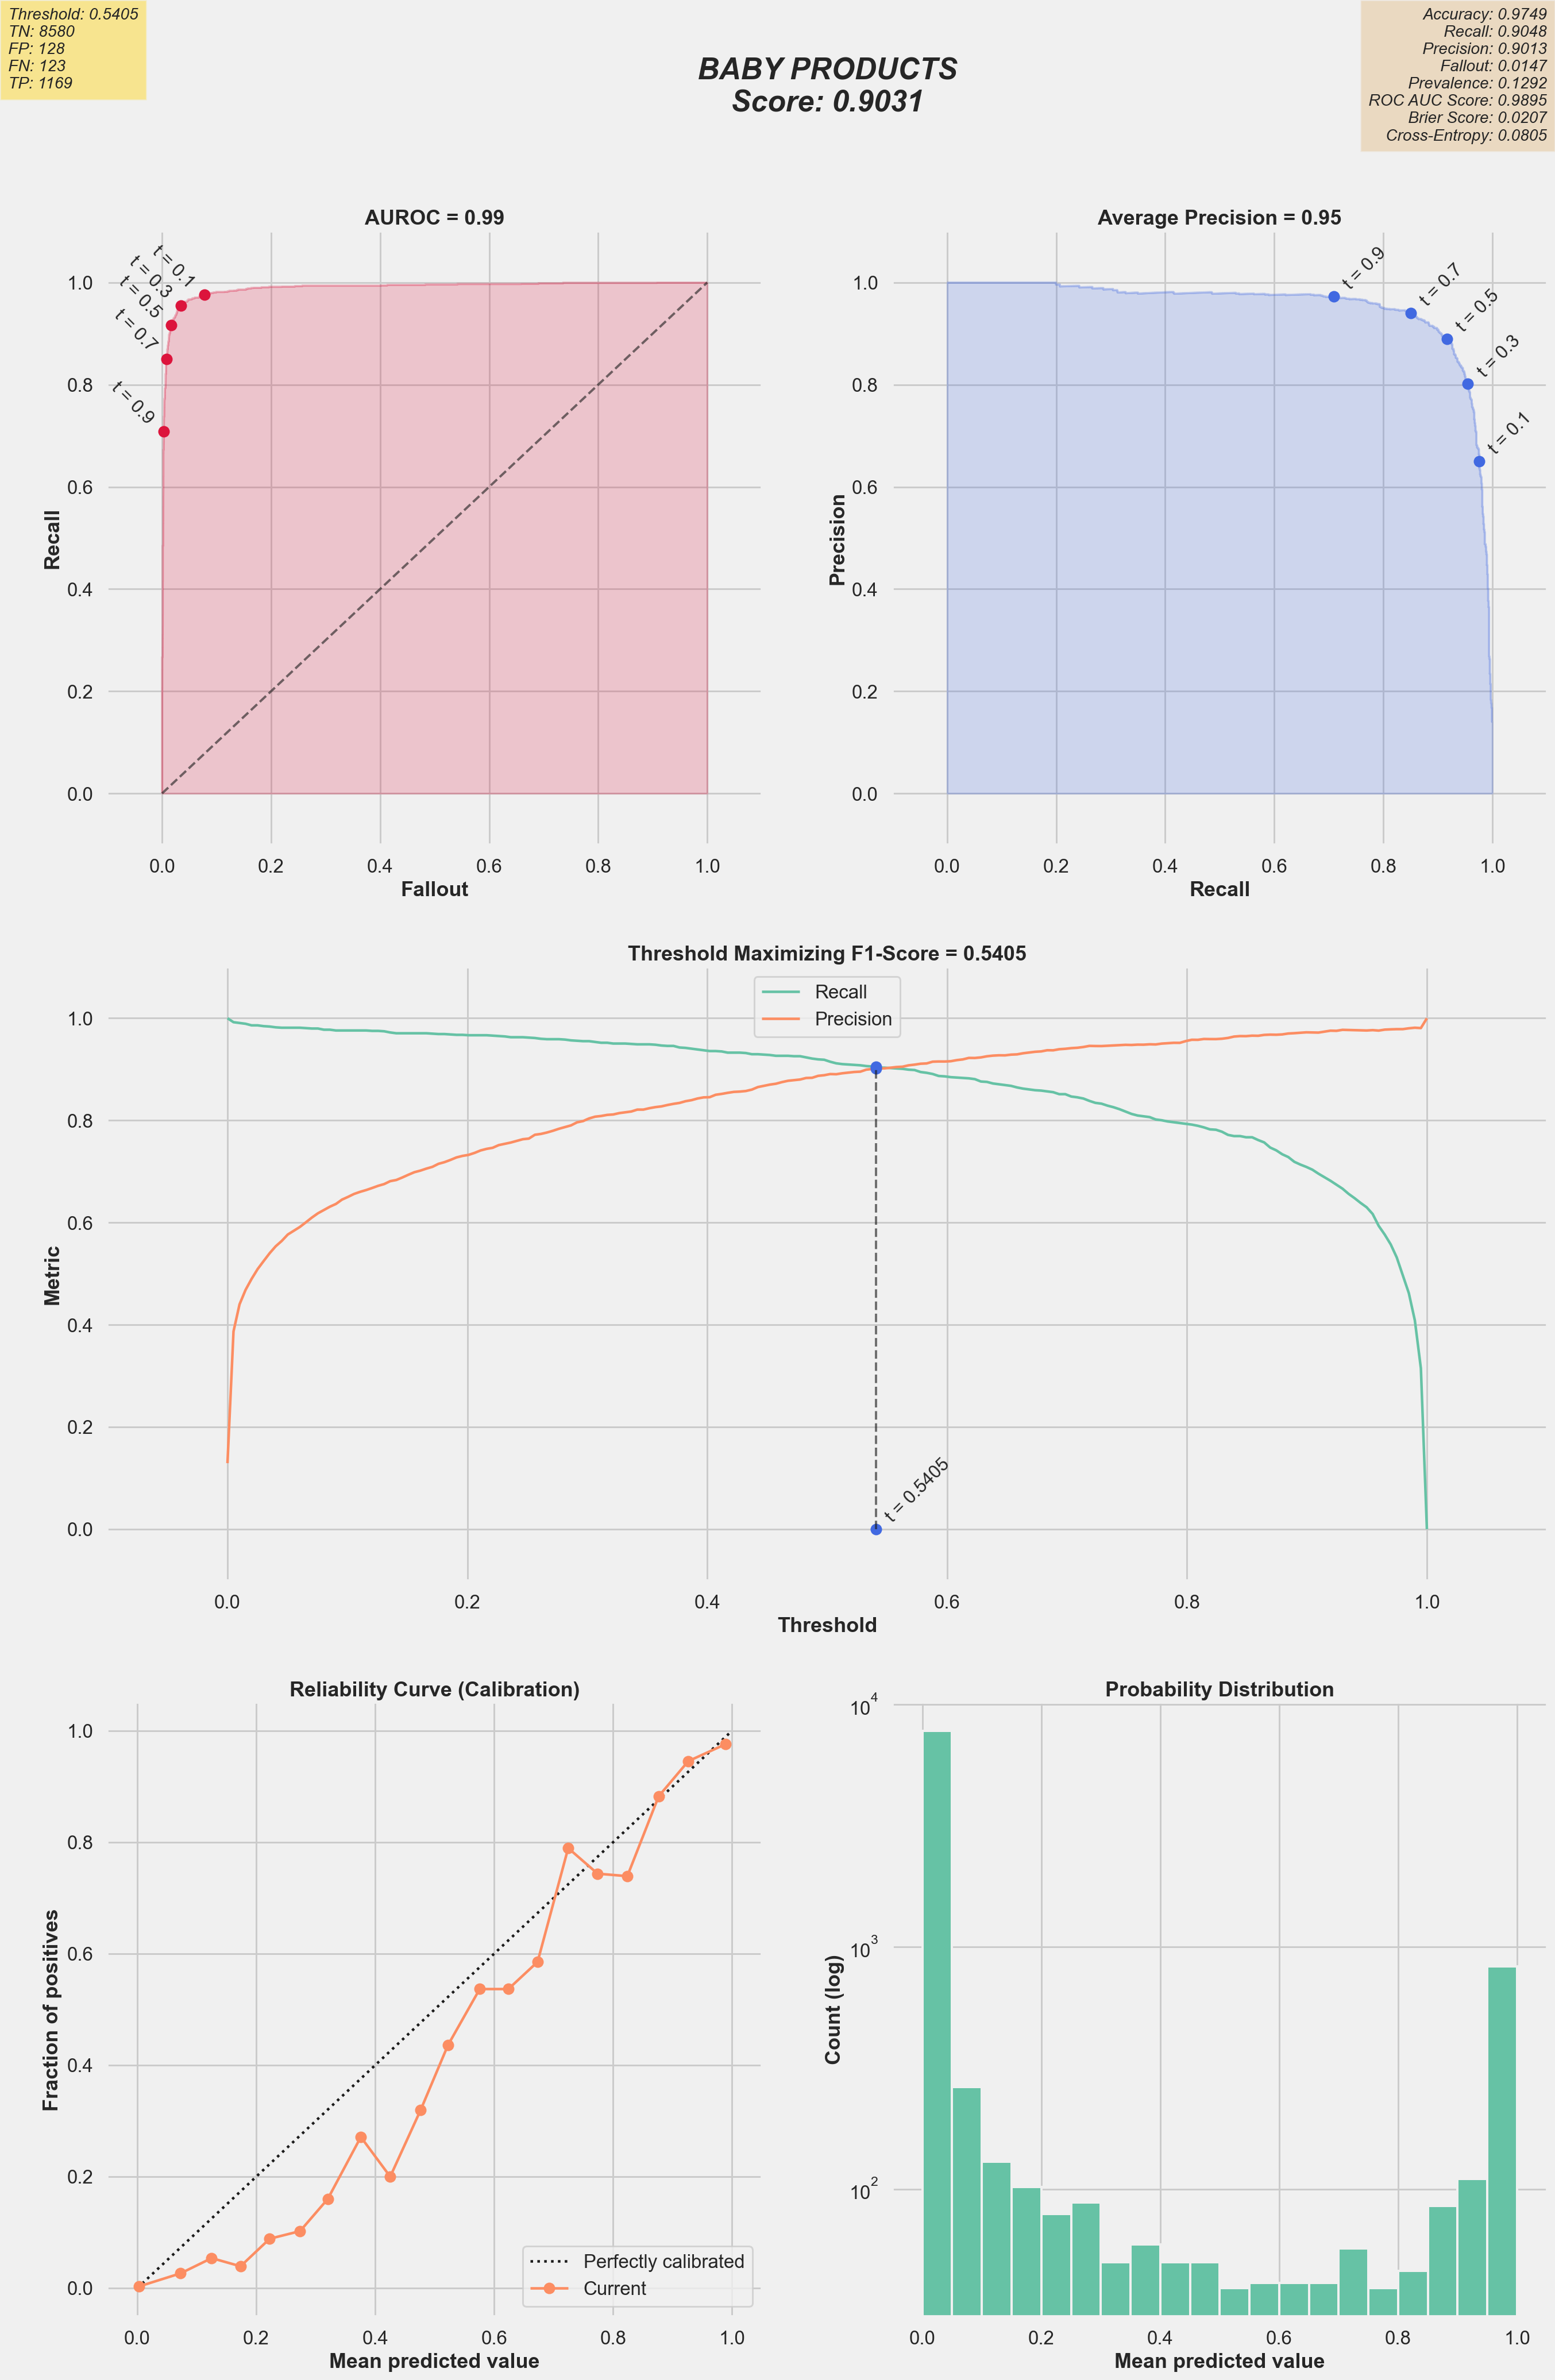

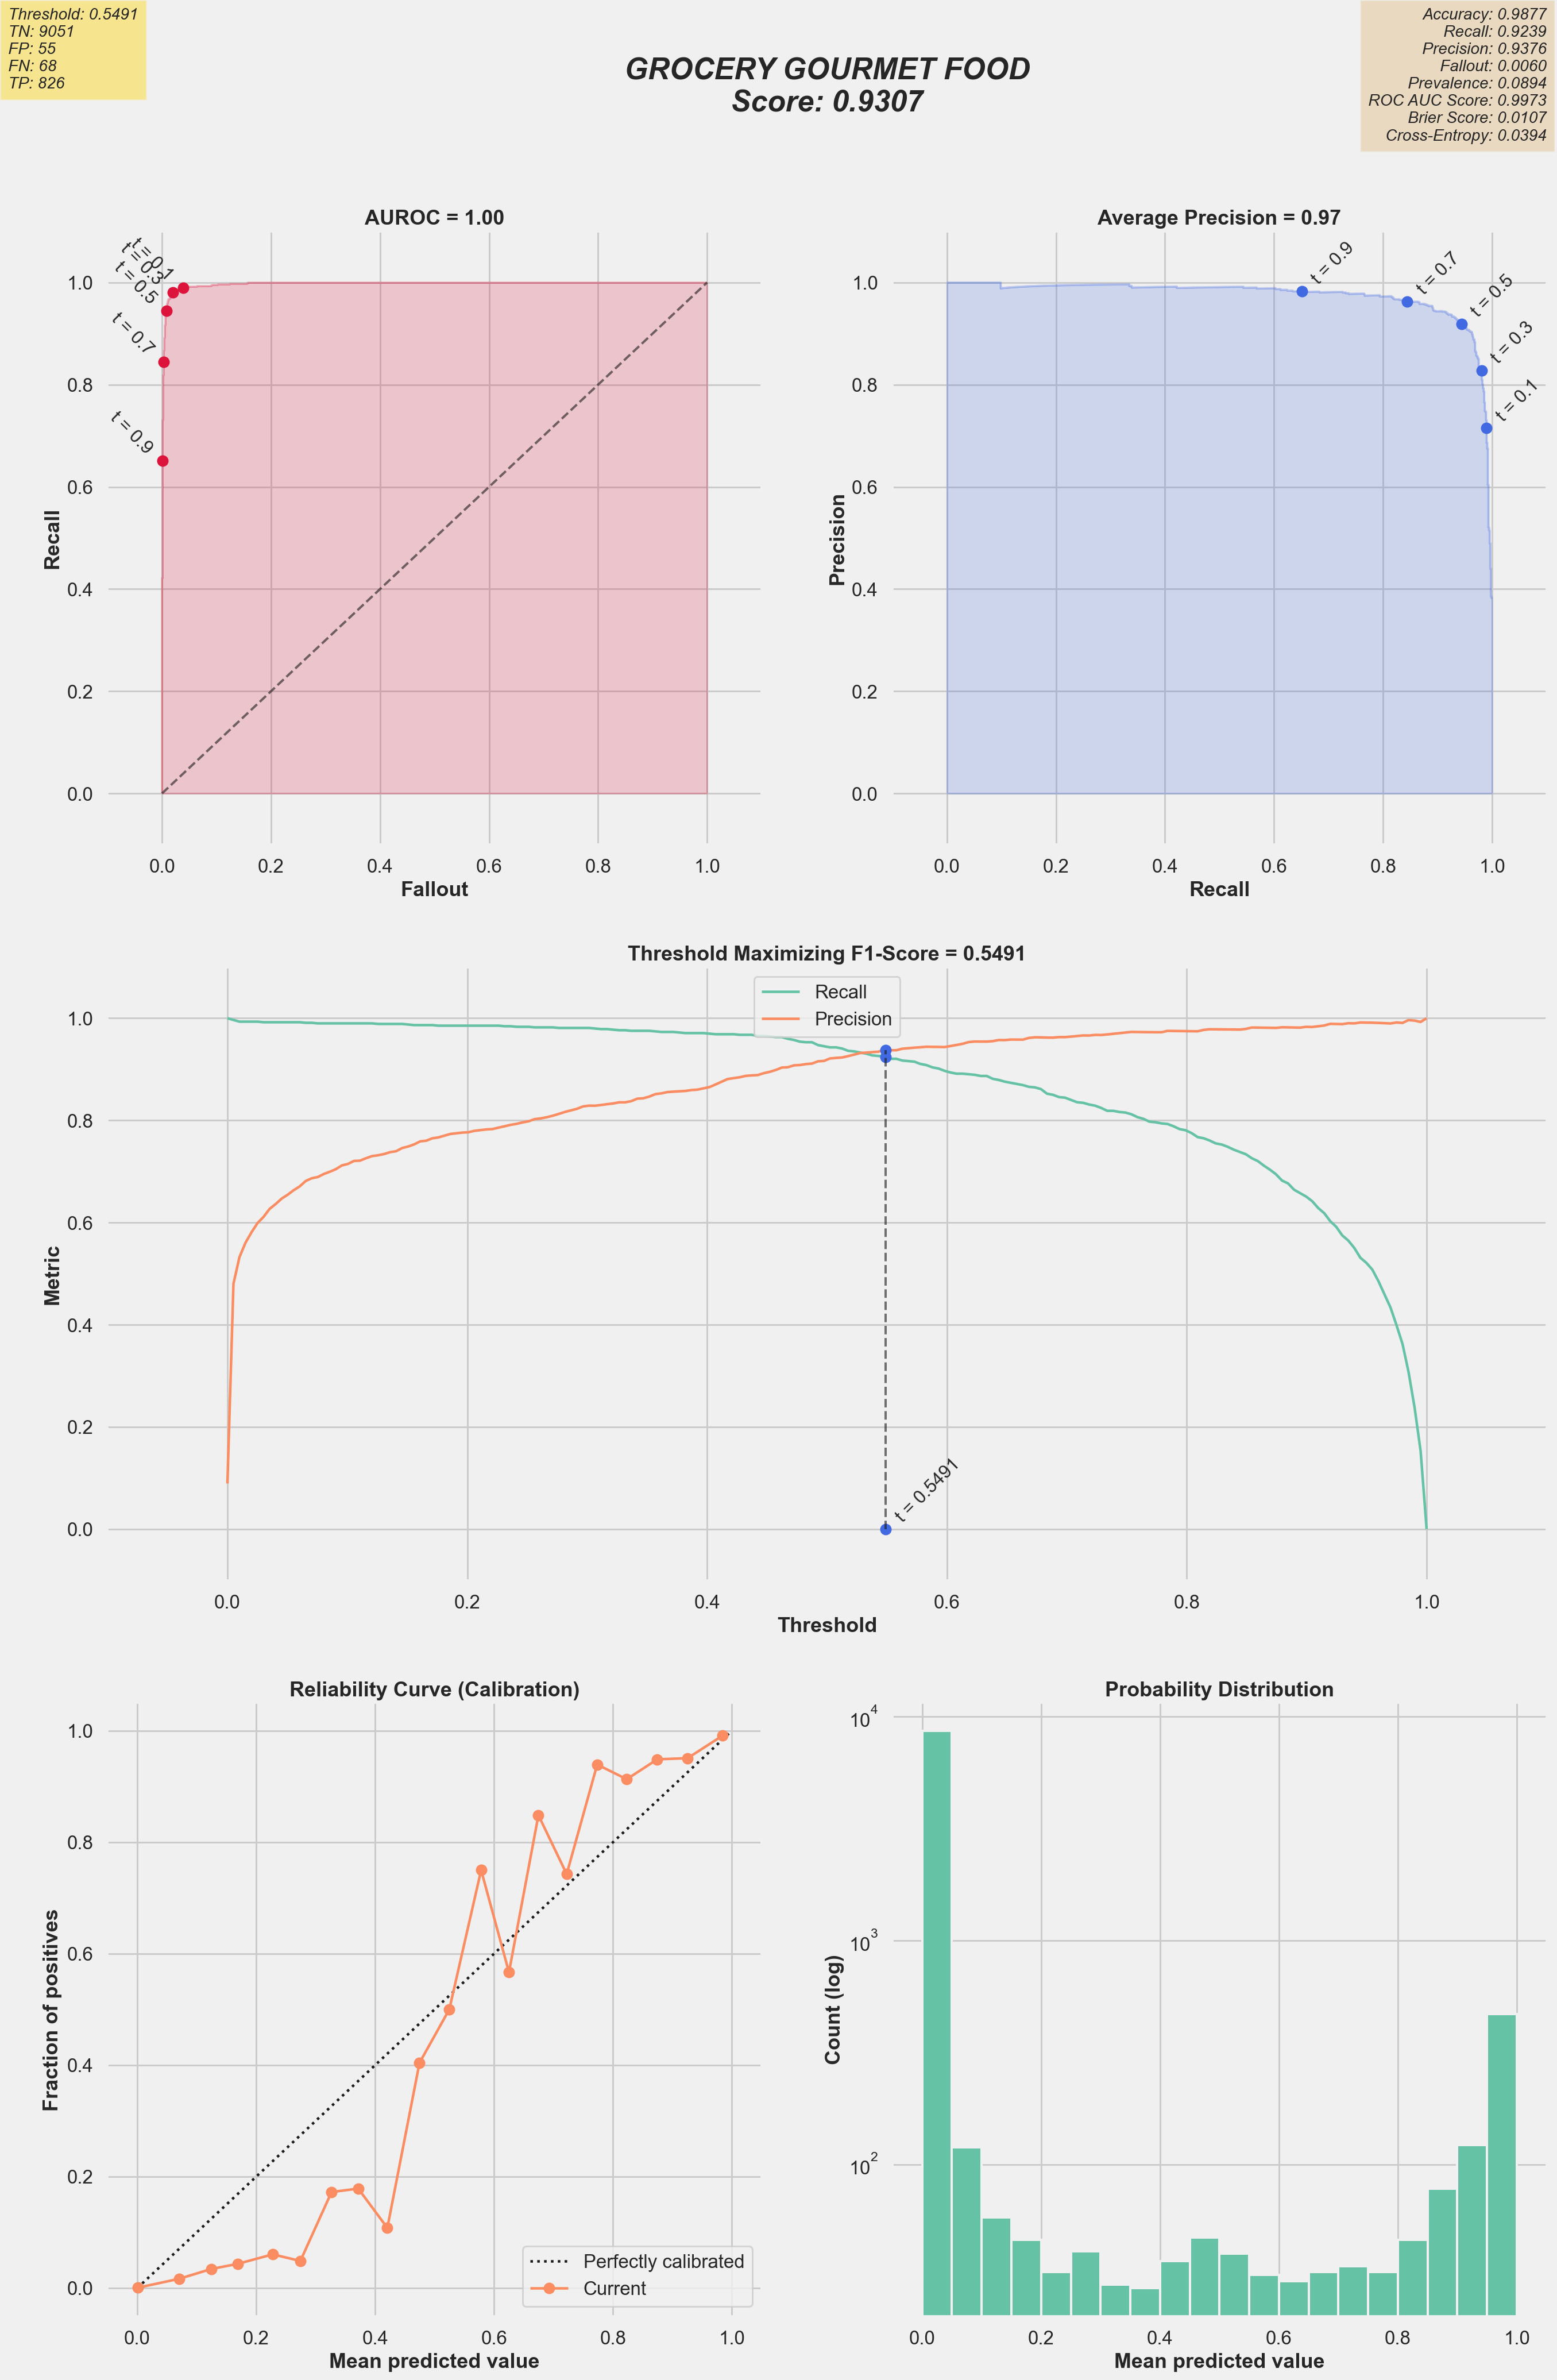

In [50]:
# Let's print out an example
model.hierarchy.plot_curves(
    X=model.hierarchy.data['testing']['X'],
    y=model.hierarchy.data['testing']['y'],
    n_bins=20,
    n_top=100)

In [51]:
df = model.hierarchy.estimator.get_metrics_by_class(
    X=model.hierarchy.data['testing']['X'],
    y=model.hierarchy.data['testing']['y'])

# show the results
df

,True Negative,False Positive,False Negative,True Positive,Prevalence,Actual Negative,Actual Positive,Predicted Negative,Predicted Positive,Predicted Correctly,Predicted Incorrectly,Accuracy,Precision,Recall,F1-Score,Fallout,ROC AUC Score,Brier Score,Cross-Entropy
Class,,,,,,,,,,,,,,,,,,,
pet supplies,8693,85,35,1187,0.1222,8778,1222,8728,1272,9880,120,0.9880,0.933176,0.971358,0.951885,0.009683,0.997809,0.010087,0.038432
toys games,7437,108,104,2351,0.2455,7545,2455,7541,2459,9788,212,0.9788,0.956080,0.957637,0.956858,0.014314,0.996638,0.017397,0.063379
health personal care,7218,227,314,2241,0.2555,7445,2555,7532,2468,9459,541,0.9459,0.908023,0.877104,0.892295,0.030490,0.980068,0.045010,0.162076
beauty,8281,137,138,1444,0.1582,8418,1582,8419,1581,9725,275,0.9725,0.913346,0.912769,0.913057,0.016275,0.992404,0.022494,0.081115
baby products,8563,145,117,1175,0.1292,8708,1292,8680,1320,9738,262,0.9738,0.890152,0.909443,0.899694,0.016651,0.989452,0.020687,0.080547
grocery gourmet food,9036,70,64,830,0.0894,9106,894,9100,900,9866,134,0.9866,0.922222,0.928412,0.925307,0.007687,0.997286,0.010698,0.039400


In [52]:
# df.to_csv('data/df.csv')

In [53]:
-> Stop here please

SyntaxError: invalid syntax (<ipython-input-53-75e3cc7ba056>, line 1)

#### Model Scores

In [54]:
HTML('<img src="docs/cmfull.jpg" width="100%" style="border: 1px solid #6a3;" />')

#### Feature Importances

In [55]:
final_name, final_estimator = model.hierarchy.estimator.model.steps[-1]

AttributeError: 'CalibratedClassifierCV' object has no attribute 'steps'

In [ ]:
vect = final_estimator.coef_[0]
a1 = vect[:512].sum()
a2 = vect[512:1024].sum()
a3 = vect[1024:].sum()
print(a1, a2, a3)

In [ ]:
idx = 0

for input_feature in model.input_features:

    embedder = model.embedders[input_feature.feature_type]
    feature_importance = final_estimator.feature_importances_[idx:idx+embedder.output_size-1].sum()
    idx += embedder.output_size
    
    print('Importance for feature "{0}": {1:.2%}'.format(
        input_feature.feature_name, 
        feature_importance))